In [3]:
import sys
sys.path.append('/home/twilliams/adaptation_abm/code')
import os
import model.model as mod
import model.base_inputs as inp
import plot.multi_scenario as plt_multi
import plot.single_run as plt_it
import matplotlib.pyplot as plt
import calibration.POM as POM
import experiments.multi_scenario_comparison as msc
import imp
import copy
import code
import tqdm
import numpy as np
import pickle
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing

In [ ]:
nreps = 100
exp_name = '2019_10_15_4'
ncores = 40

# load default params
inp_base = inp.compile()
#### OR ####
# load from POM experiment
pom_nvars = 100000
pom_nreps = 10
f = '../../outputs/{}/POM/{}_{}reps/input_params_0.pkl'.format(exp_name, pom_nvars, pom_nreps)
inp_base = pickle.load(open(f, 'rb'))
# manually specify some variables (common to all scenarios)
T = 100
inp_base['model']['T'] = T
inp_base['model']['n_agents'] = 2000
inp_base['model']['exp_name'] = exp_name
inp_base['agents']['adap_type'] = 'always'

# inp_base['agents']['land_area_init'] = np.linspace(1,2,100)

#### adaptation scenarios
scenarios = {
    'baseline' : {'model' : {'adaptation_option' : 'none'}},
    'insurance' : {'model' : {'adaptation_option' : 'insurance'}},
    'cover_crop' : {'model' : {'adaptation_option' : 'cover_crop'}},
}
shock_years = []

#### shock scenarios
# scenarios = {
#     'baseline' : {'model' : {'adaptation_option' : 'none', 'shock' : False}},
#     'shock' : {'model' : {'adaptation_option' : 'none', 'shock' : True}, 'climate' : {'shock_years' : [15], 'shock_rain' : 0.1}},
# }
# shock_years = [15]

#### RUN THE MODELS ####
mods = msc.multi_mod_run(nreps, inp_base, scenarios, ncores)

In [ ]:
lands = inp_base['agents']['land_area_init']
titles = ['Land poor','Middle','Land rich']
lss = ['-','--',':']
fig, axs = plt.subplots(1,len(lands), figsize=(5*len(lands), 4), sharey=True)
for n, land_area in enumerate(lands):
    ss = 0
    for scenario, mods_sc in mods.items():
        ## calculate the wealth mean and std dev over time
        # extract and format the wealth info
        w = mods_sc['wealth']
        all_wealth = []
        for r in range(nreps):
            agents = mods_sc['land_area'][r] == land_area
            all_wealth.append(list(w[r,:,agents]))
        all_wealth = np.array([item for sublist in all_wealth for item in sublist])
        # ^ this is (agents, time) shape
        # extract mean and variance
        probs_t = np.mean(all_wealth<=0, axis=0)

        axs[n].plot(np.arange(T+1), probs_t, label=scenario, lw=2.5, ls=lss[ss])#, marker='o')
        ss += 1

for a, ax in enumerate(axs):
    ax.grid(False)
    ax.set_xlabel('Year')
    ax.set_title(titles[a])
axs[0].set_ylabel('P(wealth = 0)')
axs[1].legend(loc=10, bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
fig.tight_layout()

# sensitivity

In [4]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import os
import model.model as mod
import model.base_inputs as inp
import calibration.POM as POM
from experiments import multi_scenario_comparison as msc
# from experiments import analysis as shock
# from experiments import sensitivity as senss
from experiments.sensitivity import *
import code
import tqdm
import numpy as np
import pyDOE
import pickle
import pandas as pd
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import partial_dependence
import logging
import logging.config
# logging.config.fileConfig('logger.conf', defaults={'logfilename' : 'logs/{}.log'.format(os.path.basename(__file__)[:-3])})
# logger = logging.getLogger('sLogger')
sys.path.append('/home/twilliams/adaptation_abm/code/experiments')

In [46]:
exp_name = '2019_10_15_4'
N_vars = 1000 # number of random variable sets to generate
N_reps = 100 # number of times to repeat model for each variable set
ncores = 40
pom_nvars = 100000
pom_nreps = 10
n_mods = 1 # number of successful POM models
perturb_perc = 30
load = True
nboot_rf = 100
sens_vars = {
    'agents' : ['wealth_init_mean','cash_req_mean','livestock_cost'],#,'land_area_multiplier'],
    'land' : ['organic_N_min_init','max_organic_N','fast_mineralization_rate',
        'slow_mineralization_rate','loss_max','loss_min','max_yield',
        'rain_crit','rain_cropfail_low_SOM','random_effect_sd',
        'crop_CN_conversion','residue_CN_conversion',
        'wealth_N_conversion','livestock_frac_crops','livestock_residue_factor'],
    'climate' : ['rain_mu','rain_sd']
}

m=0
# for m in range(n_mods):
# logger.info('model {}........'.format(m))
### 1. load the POM variables
f = '../../outputs/{}/POM/{}_{}reps/input_params_{}.pkl'.format(exp_name, pom_nvars, pom_nreps, m)
inp_base = pickle.load(open(f, 'rb'))
# manually specify some variables (common to all scenarios)
inp_base['model']['n_agents'] = 201
inp_base['model']['exp_name'] = exp_name
inp_base['agents']['adap_type'] = 'always'
inp_base['agents']['land_area_multiplier'] = 1 # not in POM experiment

### 2. sample: generate random perturbed variable sets
params, keys, names = hypercube_sample(N_vars, sens_vars, inp_base, perturb_perc)

### 3. run the policy analysis
T_shock = [10] # measured after the burn-in
T_res = [5]
T_dev = 50 # for development resilience
shock_mag = [0.1]
inp_base['model']['T'] = T_shock[0] + T_res[0] + inp_base['adaptation']['burnin_period']
Ys_dev = calculate_QoI(exp_name, params, keys, names, inp_base, N_reps, ncores, T_shock, T_res, T_dev, shock_mag, m, load, 'development')
Ys_climate = calculate_QoI(exp_name, params, keys, names, inp_base, N_reps, ncores, T_shock, T_res, T_dev, shock_mag, m, load, 'climate')

### 4. run the random forest
boot_dev = bootstrap_random_forest(Ys_dev, params, names, keys, nboot_rf, load, exp_name, m, 'development')
boot_climate = bootstrap_random_forest(Ys_climate, params, names, keys, nboot_rf, load, exp_name, m, 'climate')
# code.interact(local=dict(globals(), **locals()))
### 5. plot results
# plot_rf_results(boot_climate, Ys_climate.mean(), exp_name, m, 'climate')
# plot_rf_results(boot_dev, Ys_dev.mean(), exp_name, m, 'development')
# plot_rf_combined(boot_climate, boot_dev, Ys_climate.mean(), Ys_boot.mean(), exp_name, m)

In [144]:
mean_val_climate = Ys_climate.mean()
mean_val_dev = Ys_dev.mean()
mean_vals = [Ys_climate.mean(), Ys_dev.mean()]
d_climate = boot_climate
d_dev = boot_dev
res_types = ['climate resilience','development resilience']

In [133]:
### A: variable importance
## format the data
tmp = d_climate['var_imps_df'].copy()
tmp.columns.values[tmp.columns=='importance'] = 'importance_climate'
tmp = tmp.merge(d_dev['var_imps_df'], on=('key','variable'))
tmp.columns.values[tmp.columns=='importance'] = 'importance_development'
# sort
var_imp_df = tmp.sort_values(['key','importance_climate'], ascending=False)
var_imp_df['ix'] = np.arange(var_imp_df.shape[0])
# colors
colors = {'land' : 'b', 'climate' : 'r', 'agents' : 'k'}
var_imp_df['color'] = np.nan
for index, row in var_imp_df.iterrows():
    var_imp_df.loc[index, 'color'] = colors[row.key]
# # error bars
var_imp_df = var_imp_df.assign(upr_climate=np.nan, upr_dev=np.nan, lwr_climate=np.nan, lwr_dev=np.nan)
for k, v in d_climate['var_imps'].items():
    var_imp_df.loc[var_imp_df['variable']==k, 'upr_climate'] = np.percentile(v, q=[95])
    var_imp_df.loc[var_imp_df['variable']==k, 'lwr_climate'] = np.percentile(v, q=[5])
for k, v in d_dev['var_imps'].items():
    var_imp_df.loc[var_imp_df['variable']==k, 'upr_dev'] = np.percentile(v, q=[95])
    var_imp_df.loc[var_imp_df['variable']==k, 'lwr_dev'] = np.percentile(v, q=[5])


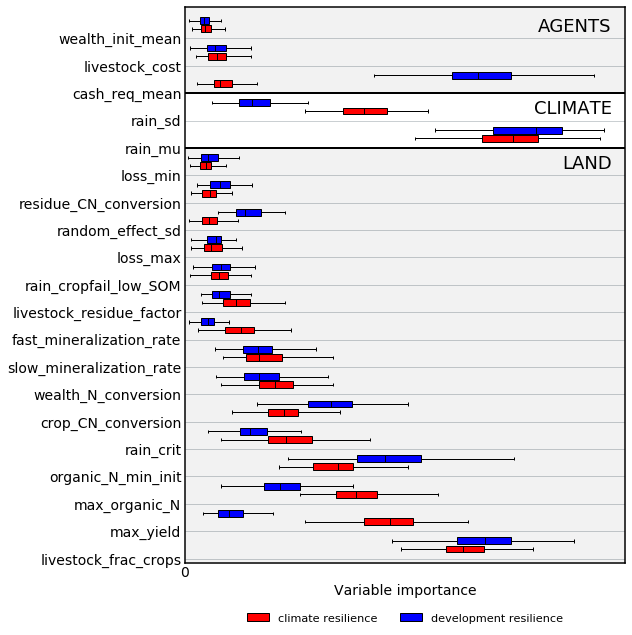

In [236]:
fig, ax = plt.subplots(figsize=(9,9))
# create the figure
bps = []
xs = np.array(var_imp_df['ix'])
for i, di in enumerate([d_climate,d_dev]):
    y_box = []
    for v in var_imp_df['variable']:
        y_box.append(di['var_imps'][v])
    y_box = np.array(y_box).transpose()
    bps.append(ax.boxplot(y_box, positions=xs+0.85+0.3*i, vert=False, patch_artist=True, 
                          showfliers=False, widths=0.25))#color=var_imp_df.color)
ax.set_yticks(xs+0.5)
ax.set_yticklabels(np.array(var_imp_df['variable']))
ax.set_xlabel('Variable importance')
ax.grid(False, axis='x')
# fill with colors
# colors = ['pink', 'lightblue', 'lightgreen']
colors = ['red','blue']
for bi, bp in enumerate(bps):
    for patch in bp['boxes']:
        patch.set_facecolor(colors[bi])
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='k')
        
ax.axhline(y=15.5, color='k',lw=2)
ax.axhline(y=17.5, color='k',lw=2)
xmx = ax.get_xlim()[1]
fsz = 18
ax.text(xmx*0.97, 15.25, 'LAND', ha='right',va='top', fontsize=fsz)
ax.text(xmx*0.97, 17.25, 'CLIMATE', ha='right',va='top', fontsize=fsz)
ax.text(xmx*0.97, 20.25, 'AGENTS', ha='right',va='top', fontsize=fsz)
ylim = ax.get_ylim()

ax.fill_between([0,xmx],[15.5,15.5],[0,0], color='k',alpha=0.05)
# ax.fill_between([0,xmx],[15.5,15.5],[17.5,17.5], color='green',alpha=0.2)
ax.fill_between([0,xmx],[17.5,17.5],[21,21], color='k',alpha=0.05)
ax.set_xlim([0,xmx])
ax.set_ylim(ylim)

ax.legend([bps[0]["boxes"][0], bps[1]["boxes"][0]], res_types, loc='center', 
          bbox_to_anchor=[0.5,-0.1], ncol=2, frameon=False)
# fig.savefig(plot_dir + 'variable_importance_boxplot_{}.png'.format(ext))
fig

In [137]:
plt.close('all')

In [140]:
d_climate.keys()

dict_keys(['var_imps_df', 'var_imps', 'pdp_datas'])

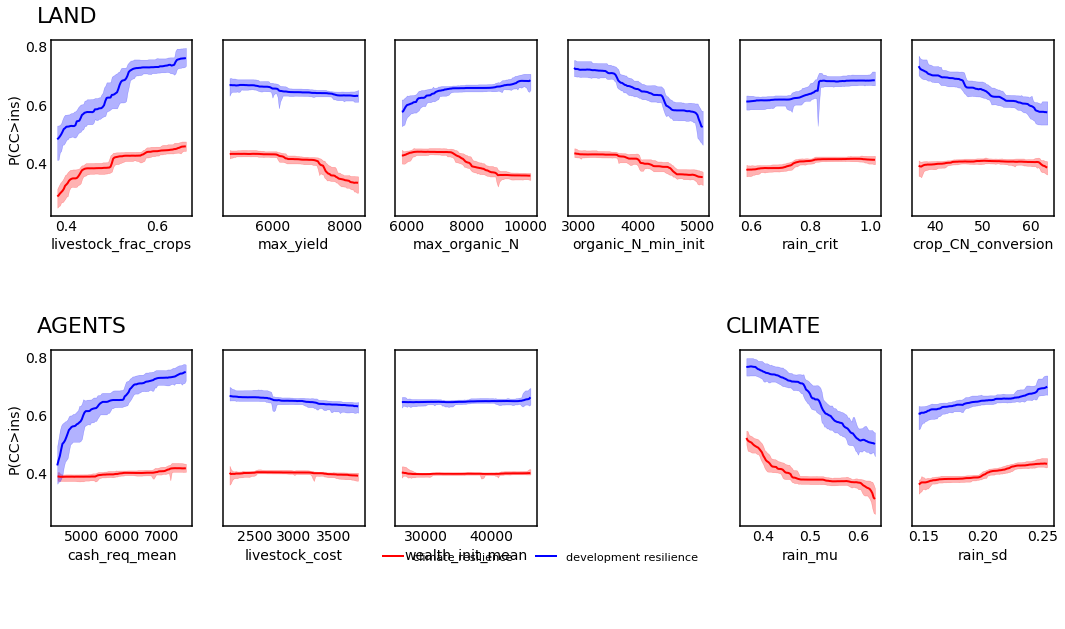

In [229]:
## PDPs
fig, axs = plt.subplots(3,6, figsize=(15,10), sharey=True, 
                        gridspec_kw={'height_ratios':[1,1,0.05]})#, 'wspace' : 0.1, 'hspace':1})
axs[1,3].remove()
[axi.remove() for axi in axs[2,:]]
axs_flat = axs.flatten()

clrs = ['red','blue']
alpha=0.3

## land
n_land = 6
for i in range(n_land):
    var = var_imp_df[var_imp_df.key=='land'].iloc[i]['variable']   
    for o, obj in enumerate([d_climate,d_dev]):
        pdp_data = obj['pdp_datas']
        xs = np.array(pdp_data[var]['x']).mean(axis=0) # note: this might fail if low Nreps since the PDP has < 100 values
        ys = np.percentile(np.array(pdp_data[var]['y']), q=[2.5,50,97.5], axis=0)
        axs[0,i].fill_between(xs, ys[0]+mean_vals[o], ys[2]+mean_vals[o], color=clrs[o], alpha=alpha)
        axs[0,i].plot(xs, ys[1]+mean_vals[o], color=clrs[o], label=res_types[o])
        axs[0,i].set_xlabel(var)

# agents
for j in range(3):
    var = var_imp_df[var_imp_df.key=='agents'].iloc[j]['variable']
    for o, obj in enumerate([d_climate,d_dev]):
        pdp_data = obj['pdp_datas']
        xs = np.array(pdp_data[var]['x']).mean(axis=0)
        ys = np.percentile(np.array(pdp_data[var]['y']), q=[2.5,50,97.5], axis=0)
        axs[1,j].fill_between(xs, ys[0]+mean_vals[o], ys[2]+mean_vals[o], color=clrs[o], alpha=alpha)
        axs[1,j].plot(xs, ys[1]+mean_vals[o], color=clrs[o], label=res_types[o])
        axs[1,j].set_xlabel(var)

# climate
for k in range(2):
    var = var_imp_df[var_imp_df.key=='climate'].iloc[k]['variable']
    for o, obj in enumerate([d_climate,d_dev]):
        pdp_data = obj['pdp_datas']
        xs = np.array(pdp_data[var]['x']).mean(axis=0)
        ys = np.percentile(np.array(pdp_data[var]['y']), q=[2.5,50,97.5], axis=0)
        axs[1,k+4].fill_between(xs, ys[0]+mean_vals[o], ys[2]+mean_vals[o], color=clrs[o], alpha=alpha)
        axs[1,k+4].plot(xs, ys[1]+mean_vals[o], color=clrs[o])
        axs[1,k+4].set_xlabel(var)

for a, ax in enumerate(axs_flat):
    ax.grid(False)
    if a % 6 == 0:
        ax.set_ylabel('P(CC>ins)')

axs[0,0].text(-0.1, 1.1, 'LAND', transform=axs[0,0].transAxes, fontsize=22)
axs[1,0].text(-0.1, 1.1, '\nAGENTS', transform=axs[1,0].transAxes, fontsize=22)
axs[1,4].text(-0.1, 1.1, 'CLIMATE', transform=axs[1,4].transAxes, fontsize=22)

# axs[1,2].legend(bbox_to_anchor=[1,-0.2], loc='center',fancybox=False, shadow=False, ncol=2)
fig.subplots_adjust(bottom=-0.3)#, wspace=0.33)
fig.legend(res_types, bbox_to_anchor=[0.5,0.1], ncol=2, loc='center', frameon=False)
# fig.savefig(plot_dir + 'partial_dependence_combined.png', bbox_inches='tight')
# code.interact(local=dict(globals(), **locals()))
# fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-0.1)
fig

In [224]:
plt.close('all')